In [12]:
import requests
from urllib.parse import urlencode
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## 1. Функция для получения датафреймов по ссылкам

Для начала создадим функцию, получающую на вход список ссылок на файлы и выдающую url этих файлов, которые мы в дальнейшем будем использовать для чтения датафреймов.

In [13]:
def get_urls (links):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    urls = []
    for i in links:
        final_url = base_url + urlencode(dict(public_key = i))
        response = requests.get(final_url)
        download_url = response.json()['href']
        urls.append(download_url)
    return(urls)

In [14]:
#создаем список ссылок, который будем передавать в функцию
groups_link = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
group_add_link = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
active_studs_link = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
checks_link = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'
all_links = [groups_link, group_add_link, active_studs_link, checks_link]

In [15]:
#применяем функцию и сохраняем ссылки в отдельную переменную
urls = get_urls(all_links)

In [16]:
groups = pd.read_csv(urls[0], sep=';')
groups_add = pd.read_csv(urls[1], sep=',')
active_studs = pd.read_csv(urls[2], sep=',')
checks = pd.read_csv(urls[3], sep=';')

## 2. Функция для подсчета метрик

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

- Функция получает на вход 4 дф: информация о студентах и группах, доп набор студентов, информация об активности и об оплате
- Переименовываем столбцы, добавляем столбцы-маркеры оплаты и активности
- Мерджим все дф в один
- создаем результирующий дф, группируем данные по группам (А и В)
- считаем кол-во уникальных студентов, кол-во активных студентов, кол-во оплат и сумму оплат
- считаем метрики ARPPU, AOV, ARPU, CR
- возвращаем результирующую таблицу

In [17]:
def table_metrics (groups, groups_add, active_studs, checks):
    active_studs = active_studs.rename(columns = {'student_id' : 'id'})
    checks = checks.rename(columns = {'student_id' : 'id'})
    active_studs['activity'] = 1
    checks['payment'] = 1

    all_groups = pd.concat([groups, groups_add])
    full_df = all_groups.merge(active_studs, on = 'id', how='left').fillna(0)\
                    .merge(checks, on = 'id', how='left').fillna(0)


    result_table = full_df.groupby('grp', as_index = False)\
        .agg({'id' : 'nunique',
          'activity' : 'sum',
          'payment' : 'sum',
          'rev' : 'sum'})\
        .rename(columns = {'id' : 'n_of_students',
                       'activity' : 'active_students',
                       'payment' : 'n_of_payments',
                      'rev' : 'sum_of_payments',})

    result_table['ARPPU'] = (full_df.query('activity == 1 and payment == 1').groupby('grp', as_index = False).rev.sum().rev/
                    full_df.query('activity == 1  and payment == 1').groupby('grp', as_index = False).id.nunique().id).round(2)
    result_table['AOV'] = (full_df.query('activity == 1 and payment == 1').groupby('grp', as_index = False).rev.sum().rev/
                    full_df.query('activity == 1  and payment == 1').groupby('grp', as_index = False).id.count().id).round(2)
    result_table['ARPU'] = (full_df.query('activity == 1').groupby('grp', as_index = False).rev.sum().rev/
                    full_df.query('activity == 1').groupby('grp', as_index = False).id.count().id).round(2)
    result_table['CR']= (full_df.query('activity == 1 and payment == 1').groupby('grp', as_index = False).id.nunique().id/
        full_df.query('activity == 1').groupby('grp', as_index = False).id.nunique().id * 100).round(2)

    return result_table

In [18]:
table_metrics (groups, groups_add, active_studs, checks)

,grp,n_of_students,active_students,n_of_payments,sum_of_payments,ARPPU,AOV,ARPU,CR
0,A,14693,1538.0,107.0,92096.0000,933.59,933.59,47.35,5.07
1,B,59883,6803.0,434.0,481230.0036,1257.88,1257.88,58.06,4.62


##3. Функция для визуализации полученных метрик

- Функция получает на вход таблицу с необходимыми метриками
- Создаем график из 8 подграфиков (2 строки, 4 столбца)
- Задаем название графика
- По координатам создаем каждый из подграфиков, задаем цвета и заголовки
- Возвращаем график, состоящий из 8 подграфиков

In [19]:
def vizualization(df):
    fig, axs = plt.subplots(2, 4, figsize=(20, 12))
    fig.suptitle('Metrics', fontsize=15, fontweight = 'bold')

    axs[0, 0].bar(df.grp, df.n_of_students, color = ['lightgreen', 'dodgerblue'])
    axs[0, 0].set_title('n_of_students \n')

    axs[0, 1].bar(df.grp, df.active_students, color = ['lightgreen', 'dodgerblue'])
    axs[0, 1].set_title('active_students \n')

    axs[0, 2].bar(df.grp, df.n_of_payments, color = ['lightgreen', 'dodgerblue'])
    axs[0, 2].set_title('n_of_payments \n')

    axs[0, 3].bar(df.grp, df.sum_of_payments, color = ['lightgreen', 'dodgerblue'])
    axs[0, 3].set_title('sum_of_payments \n')

    axs[1, 0].bar(df.grp, df.CR, color = ['lightgreen', 'dodgerblue'])
    axs[1, 0].set_title('\n CR \n')

    axs[1, 1].bar(df.grp, df.AOV, color = ['lightgreen', 'dodgerblue'])
    axs[1, 1].set_title('AOV \n')

    axs[1, 2].bar(df.grp, df.ARPU, color = ['lightgreen', 'dodgerblue'])
    axs[1, 2].set_title('ARPU \n')

    axs[1, 3].bar(df.grp, df.ARPPU, color = ['lightgreen', 'dodgerblue'])
    axs[1, 3].set_title('ARPPU \n')

    plt.show()

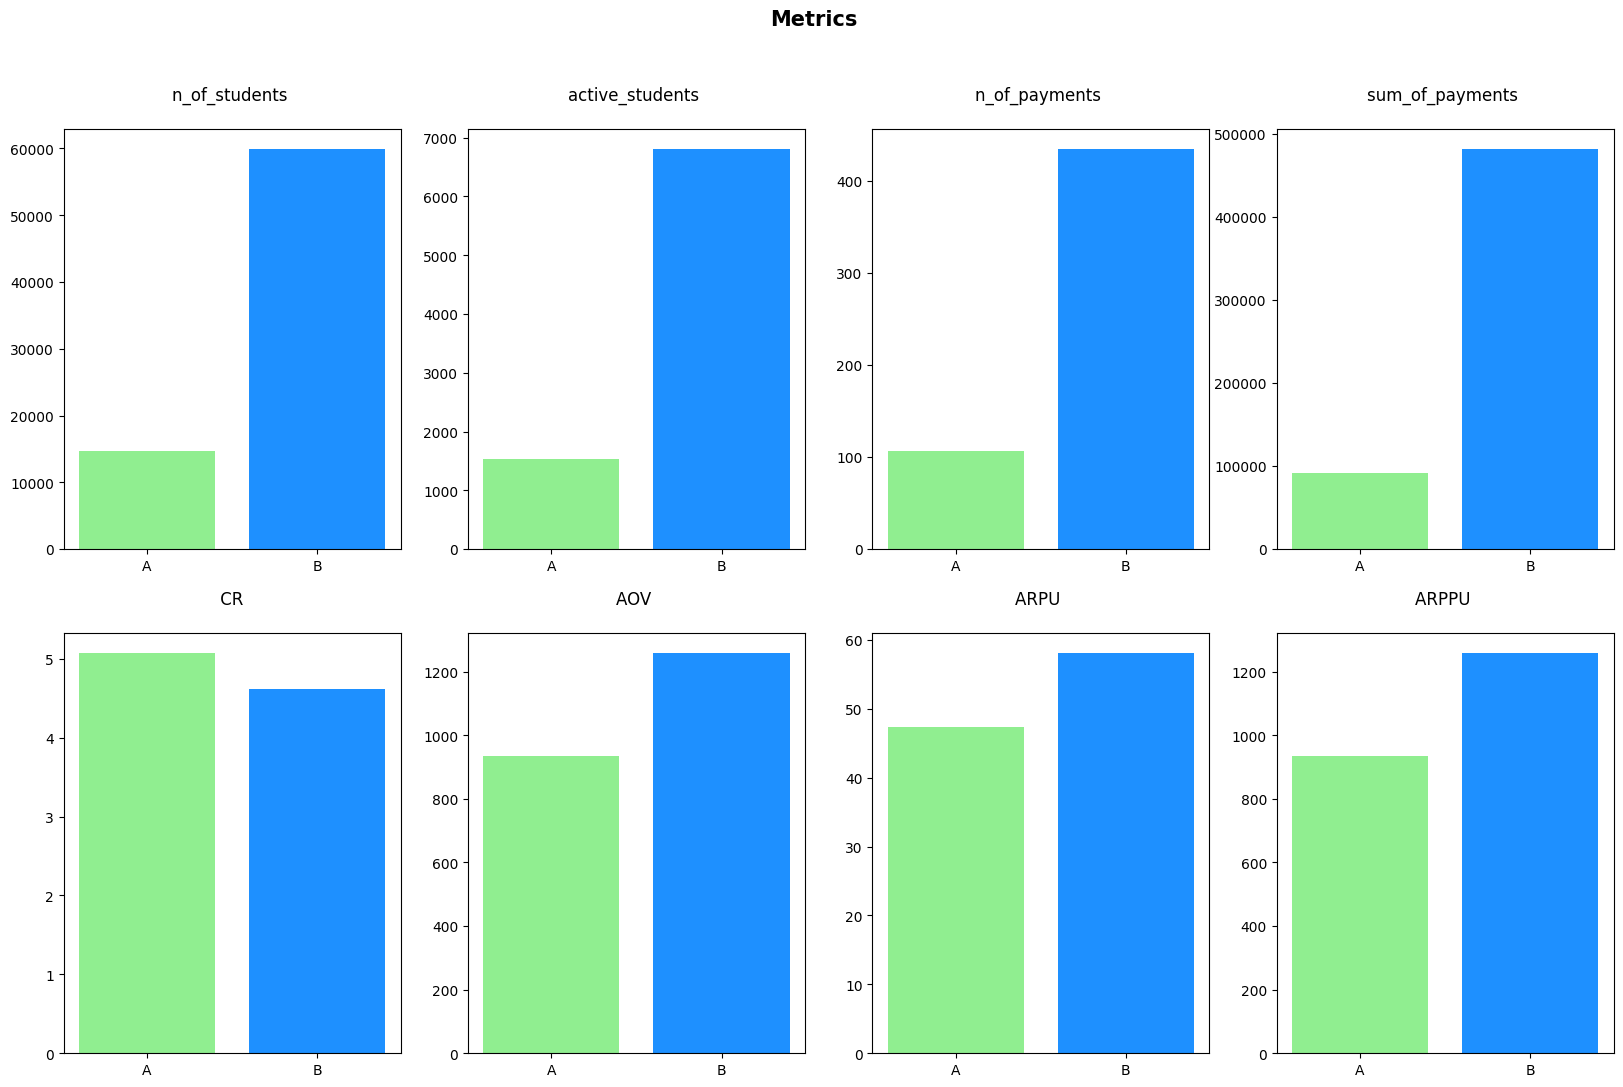

In [20]:
vizualization(table_metrics (groups, groups_add, active_studs, checks))